In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
from scipy.linalg import expm, svd
from scipy import linalg
import math
import control as ctrl
import matplotlib.pyplot as plt

In [60]:
# Define functions

def lqr_cost(A, B, Q, R, K, x_0, N):
        """
        Computes the LQR cost for a given sequence of states up to a horizon N,
        using the state cost matrix Q, the control cost matrix R, and the
        feedback gain matrix K.

        Parameters:
        Q (np.ndarray): The state cost matrix.
        R (np.ndarray): The control cost matrix.
        K (np.ndarray): The feedback gain matrix.
        x_list (List[np.ndarray]): The list of state vectors.
        N (int): The horizon up to which to compute the cost.

        Returns:
        float: The computed LQR cost.
        """
    
        pk = Q.copy()
        for t in range(N + 1):
            pk = Q + K.T @ R @ K + (A - B @ K).T @ pk @ (A - B @ K)
        cost = x_0.T @ pk @ x_0
        return cost

def gen_syn_data(M, N, dim_lat, nu, Phi_hat, F):
    # Extracting A and B matrices from M
    A = np.array(M)[:, 0:dim_lat]
    B = np.array(M)[:, dim_lat:dim_lat + nu]

    # System dynamics - Non-IID
    X = np.zeros((dim_lat + nu, N))
    Y = np.zeros((dim_lat, N + 1))
    sigu = 1
    sigw = 1

    rho = 5
    Sigma = rho * np.eye(dim_lat) + 2 * np.random.rand(dim_lat, dim_lat)
    Sigma_W = 0.5 * (Sigma + Sigma.T)

    Sigma_y = linalg.solve_discrete_lyapunov(A, (sigu ** 2) * np.dot(B, B.T) + Sigma_W)

    Ys = sqrtm(Sigma_y) @ np.random.normal(0, 1, (dim_lat, 1))
    Y[:,0] = Ys[:,0]
    
    
    M_MAP = np.dot(F,Phi_hat)
    A_MAP = np.array(M_MAP)[:, 0:dim_lat]
    B_MAP = np.array(M_MAP)[:, dim_lat:dim_lat + nu]
    
    K_MAP, _ , _ = ctrl.dlqr(A_MAP, B_MAP, np.eye(A_MAP.shape[0]), np.eye(B_MAP.shape[1]))
    
    for t in range(N):
        #u = np.random.normal(0, sigu, (nu, 1))
        w = sqrtm(Sigma_W) @ np.random.normal(0, 1, (dim_lat, 1))
        X[:dim_lat, t] = Y[:, t]
        #X[dim_lat:dim_lat+nu] = u
        X_K = np.zeros([nu,1])
        X_K[:,0] = -np.dot(K_MAP,X[:dim_lat, t])
        
        X[dim_lat:dim_lat+nu] = X_K
        Y_t_1 = np.dot(M, X[:, t]) + w
        Y[:, t+1] = Y_t_1[:,0]

    Y = Y[:, 1:]  # Remove the first column from Y

    return X, Y, A, B


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[:,t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[:,t] - np.dot(np.dot(F,Phi),X[:,t])).T,Phi_term)
    
    grad_weight = -(F[j,:])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][:,t].shape[0],1])
            X[:,0] = Xc[i][:,t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][:,t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
    grad_phi = np.zeros([r,1])
    grad_phi[:,0] = Phi[:,j]      
    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    return grad_phi



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y,cost_opt):
    

    Error_rep = []
    Log_joint_iter = []
    l=0
    F_it = []
    Phi_hat_it=[]
    Phi_it = np.zeros([Phi_hat.shape[0],Phi_hat.shape[1]])
    F_iter = np.zeros([F[0].shape[0],F[0].shape[1]])
    cost_gap = []
    for k in range(K):
        
        Phi_it = Phi_hat
        F_iter = F
        F_it.append(F_iter)
        Phi_hat_it.append(Phi_it)
        
        M_MAP_1 = np.dot(F[0],Phi_hat)
        A_MAP_1 = np.array(M_MAP_1)[:, 0:dim_lat]
        B_MAP_1 = np.array(M_MAP_1)[:, dim_lat:dim_lat + nu]
        
        # Controlling system 1 with the estimated model
        K_MAP, _ , _ = ctrl.dlqr(A_MAP_1, B_MAP_1, np.eye(A_MAP_1.shape[0]), np.eye(B_MAP_1.shape[1]))
        cost_MAP = lqr_cost(A[0], B[0], Q, R, K_MAP, x_0, 100)[0][0]
        cost_gap.append(cost_MAP - cost_opt)
        
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        
        
        X = []
        Y = []
        for h in range(H):
            [X_h,Y_h,_,_] = gen_syn_data(M[h], N, dim_lat, nu, Phi_hat, F[h])
            X.append(X_h)
            Y.append(Y_h)
        
        
       
        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][j,:] = F[h][j,:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        

       #eta_phi = eta_phi/1.0065
    
        
        end_time = time.time()
        print(f"Iteration: {l}, Subspace Dist: {Error_rep[l]}, Cost Gap: {cost_gap[l]}, Time: {end_time - start_time}")
        
        
        
        #Phi_hat_it.append(Phi_hat)
        #F_it.append(F)
        
        if math.isnan(Error_rep[l]) or Error_rep[l] <= 0.1:
            #Error_rep = Error_rep[:-1]
            #eta_phi = eta_phi/100
            #eta_F = eta_F/100
            #Phi_hat = Phi_hat_it[l-2]
            #F = F_it[l-2]
            break 
        else:
            l=l+1
        
        
    return Error_rep, Phi_hat, F, Phi_hat_it, F_it, cost_gap


$\textbf{System Parameter:}$

In [3]:
nx = 4
nu = 2

r = nx + nu  # rank

dim_lat = 25  # latent space dimension

ny = dim_lat
nx = dim_lat + nu

H = 50 # number of tasks
N = 100
lambda_F = 10

# Randomly generate the true representation
Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
Phi = Phi[0:r, :]
Phi_true = Phi

# Randomly generate the nominal task weights F
F_0 = np.zeros([ny,r])

for i in range(ny):
    for j in range(r):
        F_0[i,j] = np.random.normal(loc=0, scale=lambda_F)

F_0 = F_0 / np.linalg.norm(F_0)

M_0 = np.dot(F_0, Phi)  # Nominal operator M

# Generating different tasks weights
H = 25
scale = 0.001
F = []
P = []
for h in range(H):
    L = scale * np.random.randn(dim_lat, dim_lat)
    skewL = (L - L.T) / 2
    P.append(expm(skewL))
    F.append(np.dot(P[h], F_0))

M = []
for h in range(H):
    M.append(np.dot(F[h], Phi))  # Generating the true operators M for H different tasks

In [4]:
#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

X = []
Y = []
A = []
B = []
for h in range(H):
    [X_h,Y_h,A_h,B_h] = gen_syn_data(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)
    A.append(A_h)
    B.append(B_h)

In [37]:
# Controlling system 1 with the ground truth model
Q = np.eye(A[0].shape[0])
R = np.eye(B[0].shape[1])
K_true, _ , _ = ctrl.dlqr(A[0],B[0],Q,R)  

#Initial condition 
x_0 = np.ones([A[0].shape[0],1])

cost_opt = lqr_cost(A[0], B[0], Q, R, K_true, x_0, 100)[0][0]
cost_opt

26.24722795736041

$\textbf{Coordinate Ascent MAP Estimation:}$

In [5]:
#K = 2500 #number of global iterations
#N = 100  #number of samples

#lambda_phi = 7.5
#sigma = 0.06

#eta_F = 1e-6
#eta_phi = 0.75e-6

#Phi_hat = Phi_true.dot(rot)

In [72]:
K = 2500 #number of global iterations
N = 100  #number of samples

lambda_phi = 10
sigma = 0.06

eta_F = 1e-6
eta_phi = 0.3e-6

Phi_hat = Phi_true.dot(rot)

$\textbf{Multi-task Estimation}\;\ (M = 10)$

In [73]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP, Phi_MAP, F_MAP, Phi_hat_it, F_it, cost_gap = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data, cost_opt)

Iteration: 0, Subspace Dist: 2.2122394018212135, Cost Gap: 0.0023084428085162756, Time: 0.5357434749603271
Iteration: 1, Subspace Dist: 2.2045957319914153, Cost Gap: 0.009160142479970546, Time: 0.5320010185241699
Iteration: 2, Subspace Dist: 2.1973590212461107, Cost Gap: 0.02697250604020951, Time: 0.5595204830169678
Iteration: 3, Subspace Dist: 2.188577028329267, Cost Gap: 0.03999288411446145, Time: 0.5466842651367188
Iteration: 4, Subspace Dist: 2.190477247414973, Cost Gap: 0.03627976240055375, Time: 0.5583240985870361
Iteration: 5, Subspace Dist: 2.184536317386127, Cost Gap: 0.06284278771229879, Time: 0.5453565120697021
Iteration: 6, Subspace Dist: 2.174968636785651, Cost Gap: 0.10153453011156088, Time: 0.5441343784332275
Iteration: 7, Subspace Dist: 2.17155114511508, Cost Gap: 0.10725678309428943, Time: 0.5418038368225098
Iteration: 8, Subspace Dist: 2.1631404969969052, Cost Gap: 0.14978216775436692, Time: 0.562713623046875
Iteration: 9, Subspace Dist: 2.1528928873726163, Cost Gap: 

Iteration: 79, Subspace Dist: 1.8194014850458378, Cost Gap: 0.07303763668163299, Time: 0.5342237949371338
Iteration: 80, Subspace Dist: 1.8147159216405497, Cost Gap: 0.0457487783230377, Time: 0.5234236717224121
Iteration: 81, Subspace Dist: 1.808683476800671, Cost Gap: 0.0905901000316689, Time: 0.553661584854126
Iteration: 82, Subspace Dist: 1.8423891834416302, Cost Gap: 0.06756403418000545, Time: 0.5317668914794922
Iteration: 83, Subspace Dist: 1.85899820047579, Cost Gap: 0.05851212692187602, Time: 0.5282671451568604
Iteration: 84, Subspace Dist: 1.875070171618724, Cost Gap: 0.0367178627877891, Time: 0.5529530048370361
Iteration: 85, Subspace Dist: 1.839924864326934, Cost Gap: 0.030941342392658555, Time: 0.7097892761230469
Iteration: 86, Subspace Dist: 1.8394263030993498, Cost Gap: 0.08309982235355307, Time: 0.5961542129516602
Iteration: 87, Subspace Dist: 1.84017093048615, Cost Gap: 0.06498053947352389, Time: 0.6220340728759766
Iteration: 88, Subspace Dist: 1.8221182977074102, Cost G

Iteration: 157, Subspace Dist: 1.6054792506057465, Cost Gap: 0.057018437967801816, Time: 0.5504827499389648
Iteration: 158, Subspace Dist: 1.634881082231747, Cost Gap: 0.04167892021410324, Time: 0.5602455139160156
Iteration: 159, Subspace Dist: 1.5872436749283367, Cost Gap: 0.08885773658627372, Time: 0.5353467464447021
Iteration: 160, Subspace Dist: 1.6130114177022523, Cost Gap: 0.07101343997282328, Time: 0.5431206226348877
Iteration: 161, Subspace Dist: 1.5948563267159068, Cost Gap: 0.07877905995099255, Time: 0.5578579902648926
Iteration: 162, Subspace Dist: 1.5698271822044685, Cost Gap: 0.1411950915080169, Time: 0.5558297634124756
Iteration: 163, Subspace Dist: 1.590320066255214, Cost Gap: 0.20173732395318567, Time: 0.5551090240478516
Iteration: 164, Subspace Dist: 1.516761826482061, Cost Gap: 0.3346089729985948, Time: 0.5447089672088623
Iteration: 165, Subspace Dist: 1.5068025590285146, Cost Gap: 0.47667588982366027, Time: 0.5486626625061035
Iteration: 166, Subspace Dist: 1.54262138

Iteration: 234, Subspace Dist: 1.2651851333518704, Cost Gap: 0.07176182855313584, Time: 0.6541879177093506
Iteration: 235, Subspace Dist: 1.2733773047394148, Cost Gap: 0.12282976528643985, Time: 0.6579692363739014
Iteration: 236, Subspace Dist: 1.2668242930274303, Cost Gap: 0.09415178078312891, Time: 0.6584539413452148
Iteration: 237, Subspace Dist: 1.3072498358452296, Cost Gap: 0.08667828656343346, Time: 0.7074220180511475
Iteration: 238, Subspace Dist: 1.3392042539334001, Cost Gap: 0.12627783191658892, Time: 0.7453999519348145
Iteration: 239, Subspace Dist: 1.261766896619175, Cost Gap: 0.12269723588255488, Time: 0.6707484722137451
Iteration: 240, Subspace Dist: 1.3031565733310424, Cost Gap: 0.07649779279293512, Time: 0.5888159275054932


C:\Users\Leonardo Toso\AppData\Local\Temp\ipykernel_9148\3620183228.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  Y[:, t+1] = Y_t_1[:,0]


Iteration: 241, Subspace Dist: 1.3127265451812882, Cost Gap: 0.060544330404983526, Time: 0.639202356338501
Iteration: 242, Subspace Dist: 1.3095987901130317, Cost Gap: 0.05975051512193019, Time: 0.5860517024993896
Iteration: 243, Subspace Dist: 1.3231025942200592, Cost Gap: 0.04364643008655733, Time: 0.6638844013214111
Iteration: 244, Subspace Dist: 1.3022213970508452, Cost Gap: 0.052968035982150496, Time: 0.5472078323364258
Iteration: 245, Subspace Dist: 1.262344284280398, Cost Gap: 0.05923636611465355, Time: 0.5828514099121094
Iteration: 246, Subspace Dist: 1.2486281686629637, Cost Gap: 0.05197997051259051, Time: 0.5457203388214111
Iteration: 247, Subspace Dist: 1.2498756105569289, Cost Gap: 0.12744814208966915, Time: 0.5611906051635742
Iteration: 248, Subspace Dist: 1.2906394279604492, Cost Gap: 0.09875510324680192, Time: 0.5362410545349121
Iteration: 249, Subspace Dist: 1.2976181403894742, Cost Gap: 0.08315372452139513, Time: 0.5368919372558594
Iteration: 250, Subspace Dist: 1.2777

Iteration: 319, Subspace Dist: 1.224231058755688, Cost Gap: 0.11642548454852886, Time: 0.7400732040405273
Iteration: 320, Subspace Dist: 1.2485057565467312, Cost Gap: 0.08759709209848765, Time: 0.5607404708862305
Iteration: 321, Subspace Dist: 1.2718060562458962, Cost Gap: 0.08684287128220092, Time: 0.5482606887817383
Iteration: 322, Subspace Dist: 1.2933902878792787, Cost Gap: 0.0689343708907586, Time: 0.5628519058227539
Iteration: 323, Subspace Dist: 1.3076935035623143, Cost Gap: 0.043433553762803, Time: 0.5850412845611572
Iteration: 324, Subspace Dist: 1.343582134321478, Cost Gap: 0.027305088713745818, Time: 0.5531265735626221
Iteration: 325, Subspace Dist: 1.3435529683586453, Cost Gap: 0.028561485672042863, Time: 0.5661113262176514
Iteration: 326, Subspace Dist: 1.3295121364252735, Cost Gap: 0.03631863651339984, Time: 0.5407412052154541
Iteration: 327, Subspace Dist: 1.3025430513221299, Cost Gap: 0.05295934964639315, Time: 0.5347254276275635
Iteration: 328, Subspace Dist: 1.3085394

Iteration: 396, Subspace Dist: 1.3417616680158608, Cost Gap: 0.06024471637735118, Time: 0.601015567779541
Iteration: 397, Subspace Dist: 1.3518280143048356, Cost Gap: 0.04519639726710878, Time: 0.6068019866943359
Iteration: 398, Subspace Dist: 1.315415707675245, Cost Gap: 0.07492033401701548, Time: 0.5383589267730713
Iteration: 399, Subspace Dist: 1.3198126203570535, Cost Gap: 0.061404361602562574, Time: 0.5429427623748779
Iteration: 400, Subspace Dist: 1.2874165198631429, Cost Gap: 0.08879930304267702, Time: 2.3023617267608643
Iteration: 401, Subspace Dist: 1.290796269740006, Cost Gap: 0.07010491498228077, Time: 2.575303316116333
Iteration: 402, Subspace Dist: 1.353086872737323, Cost Gap: 0.04217768185298354, Time: 0.6108567714691162
Iteration: 403, Subspace Dist: 1.3382544720252658, Cost Gap: 0.06907376287779599, Time: 0.5888075828552246
Iteration: 404, Subspace Dist: 1.3571075978691953, Cost Gap: 0.04935597056705987, Time: 0.609804630279541
Iteration: 405, Subspace Dist: 1.346950336

KeyboardInterrupt: 

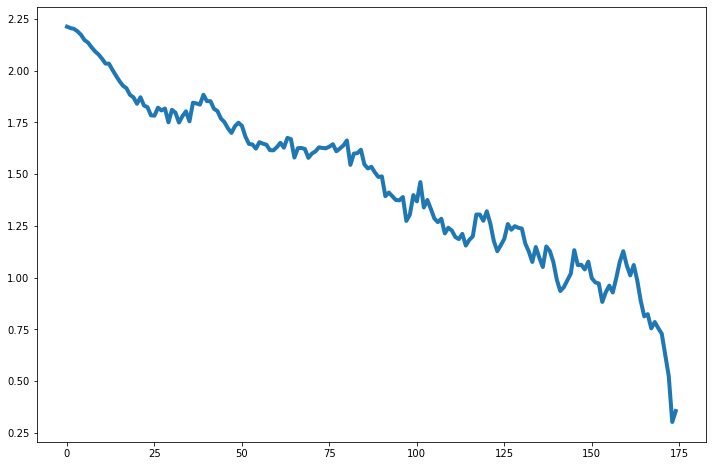

In [71]:
# Error Representation

# Create a plot to show the convergence of the (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(len(Error_CAMAP)))), Error_CAMAP, linestyle='-', linewidth=4)

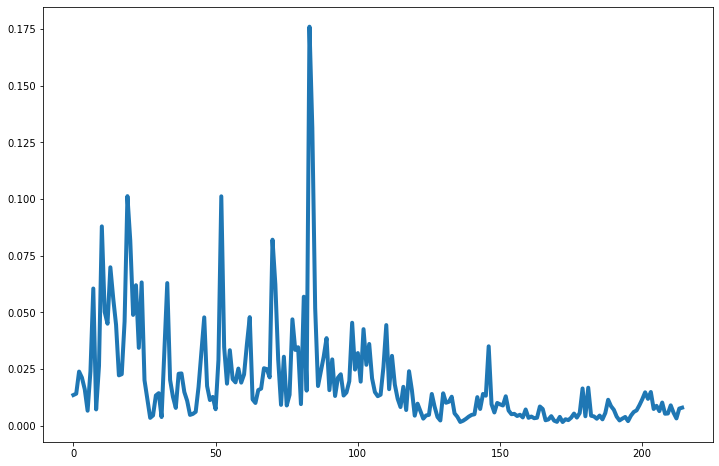

In [64]:
#Cost Gap

# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(len(cost_gap)))), cost_gap, linestyle='-', linewidth=4)